In [2]:
import numpy as np
import pandas as pd
import re

In [3]:
class Layer:
    def __init__(self, number, size, inputs=1):
        self.number = number
        self.size = size
        self.data = np.zeros((inputs, size), dtype=np.float64)

class Weight:
    def __init__(self, prev, next):
        self.value = (np.random.randn(prev.size, next.size).astype(np.float64))

class Bias:
    def __init__(self, next):
        self.value = np.random.randn(1, next.size).astype(np.float64)

class Neural:
    def __init__(self, activation):
        self.activation = activation
        self.layers = []
        self.weights = []
        self.biases = []

    def add_layer(self, layer):
        self.layers.append(layer)
        if len(self.layers) > 1:
            self.weights.append(Weight(self.layers[-2], self.layers[-1]))
            self.biases.append(Bias(self.layers[-1]))

    def forward(self):
        self.z_values = []
        self.a_values = []
        for i in range(1, len(self.layers)):
            prev_data = self.layers[i - 1].data
            w = self.weights[i - 1].value
            b = self.biases[i - 1].value
            z = np.dot(prev_data, w) + b
            self.z_values.append(z)
            a = self.activation(z)
            self.a_values.append(a)
            self.layers[i].data = a

    @property
    def output(self):
        return self.layers[-1].data


In [16]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    s = sigmoid(x)
    return s * (1 - s)

def costFunction(predicted, real):
    return np.mean((predicted - real) ** 2)


In [17]:
# ---------------------- Text Processor ---------------------- #
class TextProcessor:
    def __init__(self):
        self.vocab = {}

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r"<.*?>", "", text)
        text = re.sub(r"[^a-zA-Z']", " ", text)
        return text

    def build_vocab(self, texts):
        words = set()
        for sentence in texts:
            words.update(sentence.split())
        self.vocab = {word: i for i, word in enumerate(words)}

    def vectorize(self, sentence):
        vec = np.zeros(len(self.vocab))
        for word in sentence.split():
            if word in self.vocab:
                vec[self.vocab[word]] += 1
        return vec

    def process(self, df, text_column):
        df[text_column] = df[text_column].apply(self.clean_text)
        self.build_vocab(df[text_column])
        vectors = np.array([self.vectorize(text) for text in df[text_column]])
        norms = np.max(vectors, axis=1, keepdims=True)
        norms[norms == 0] = 1  # Avoid divide-by-zero
        return vectors / norms


In [18]:
def delta_lastlayer(real, predicted, z):
    return (predicted - real) * sigmoid_prime(z)

def delta_calc(model, current_layer_idx, next_delta=None, next_weight=None):
    z = model.z_values[current_layer_idx]
    if next_delta is None:
        return delta_lastlayer(y, model.output, z)
    else:
        return np.dot(next_delta, next_weight.T) * sigmoid_prime(z)

def dJdW(model, layer_idx, delta):
    a_prev = model.layers[layer_idx].data
    return np.dot(a_prev.T, delta)

def dJdB(delta):
    return np.sum(delta, axis=0, keepdims=True)



In [19]:
file = pd.read_csv("IMDB Dataset.csv")
file = file[2000:4000:1]
file['sentiment'] = file['sentiment'].map({'positive': 1, 'negative': 0})

processor = TextProcessor()
X = processor.process(file, 'review')
labels = file['sentiment'].values
y = np.zeros((len(labels), 2))
for i, label in enumerate(labels):
    y[i][label] = 1  # label 0 → [1,0] (negative), label 1 → [0,1] (positive)



In [20]:
model = Neural(sigmoid)
model.add_layer(Layer(0, X.shape[1], inputs = X.shape[0]))
model.layers[0].data = X
model.add_layer(Layer(1, 116, inputs = X.shape[0]))
model.add_layer(Layer(2, 16, inputs = X.shape[0]))
model.add_layer(Layer(3, 2, inputs = X.shape[0]))








In [21]:
numberoflayers = 3

In [22]:
#Trainig

epochs = 1000
learningRate = 0.01

lossList =[]

for epoch in range(epochs):
    model.layers[0].data = X
    model.forward()
    predicted = model.output
    loss = costFunction(predicted, y)
    lossList.append(loss)
    
    delta_list = [None] * numberoflayers
    delta_output = delta_calc(model, -1)
    delta_list[-1] = delta_output
    
    
    
    for i in reversed(range(len(model.weights) - 1)):
        next_delta = delta_list[i + 1]
        next_weight = model.weights[i + 1].value
        delta_list[i] = delta_calc(model, i, next_delta, next_weight)

    for i in range(len(model.weights)):
        dw = dJdW(model, i, delta_list[i])
        db = dJdB(delta_list[i])
        model.weights[i].value -= learningRate * dw
        model.biases[i].value -= learningRate * db
    predicted_labels = np.argmax(predicted, axis=1)
    actual_labels = np.argmax(y, axis=1)
    accuracy = np.mean(predicted_labels == actual_labels) * 100


    if (epoch % 10 == 0 or epoch == epochs -1):
        print("Epoch : ", epoch, "Loss: ", loss, "Accuracy : ", accuracy,"%")

print("Final loss: ", loss)

Epoch :  0 Loss:  0.48166846112856276 Accuracy :  47.15 %
Epoch :  10 Loss:  0.3608609219685936 Accuracy :  48.3 %
Epoch :  20 Loss:  0.3426134297912149 Accuracy :  52.55 %
Epoch :  30 Loss:  0.4281071779890542 Accuracy :  52.449999999999996 %
Epoch :  40 Loss:  0.28897682421368054 Accuracy :  53.15 %
Epoch :  50 Loss:  0.2615089629508278 Accuracy :  61.75000000000001 %
Epoch :  60 Loss:  0.3067199954276589 Accuracy :  51.9 %
Epoch :  70 Loss:  0.3341389713974339 Accuracy :  51.65 %
Epoch :  80 Loss:  0.3760150597703877 Accuracy :  51.65 %
Epoch :  90 Loss:  0.3761209453386007 Accuracy :  51.6 %
Epoch :  100 Loss:  0.3782474255021181 Accuracy :  51.6 %
Epoch :  110 Loss:  0.3605579003204364 Accuracy :  51.65 %
Epoch :  120 Loss:  0.37718770043553634 Accuracy :  51.6 %
Epoch :  130 Loss:  0.3707761152928765 Accuracy :  51.7 %
Epoch :  140 Loss:  0.3203754120218149 Accuracy :  52.05 %
Epoch :  150 Loss:  0.33017322064284405 Accuracy :  52.05 %
Epoch :  160 Loss:  0.31811627574532636 Accu

KeyboardInterrupt: 

In [23]:
print(loss)

0.29549095865218056


In [24]:
import matplotlib.pyplot as plt

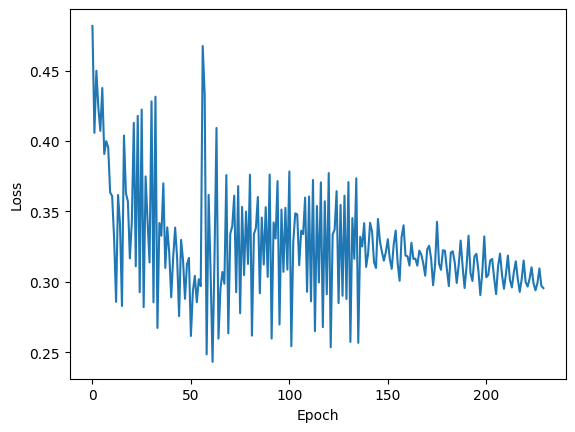

In [25]:
plt.plot(lossList)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
# print("Layer", i, "a_prev shape:", model.layers[i].data.shape, "delta shape:", delta_list[i].shape)


Layer 0 a_prev shape: (1, 26664) delta shape: (2000, 32)


In [ ]:
text = input("Enter a text: ")
cleaned = processor.clean_text(text)
vec = processor.vectorize(cleaned).reshape(1, -1)
vec = vec / np.max(vec)
model.layers[0].data = vec
model.forward()
output = model.output[0]
label = np.argmax(output)
print(text, "\n")
if (label == 0):
    print("Negative")
else:
    print("Positive")

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends. 

Positive


In [ ]:
print(file[0:5:2])

                                              review  sentiment
0  one of the other reviewers has mentioned that ...          1
2  i thought this was a wonderful way to spend ti...          1
4  petter mattei's  love in the time of money  is...          1


In [ ]:
import pickle

In [ ]:
import pickle

def save_model(model, filename="model.pkl"):
    data = {
        "weights": [w.value for w in model.weights],
        "biases": [b.value for b in model.biases]
    }
    with open(filename, "wb") as f:
        pickle.dump(data, f)

    print("File saved")
    


In [ ]:
save_model(model)


File saved


In [ ]:
def load_model(model, filename="model.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    for i in range(len(model.weights)):
        model.weights[i].value = data["weights"][i]
        model.biases[i].value = data["biases"][i]
    
    print("File loaded ")

In [ ]:
# load_model(model)


File loaded 
